In [1]:
import os
#os.environ["OMP_NUM_THREADS"]="1"
import random
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import transforms
import numpy as np
import toml
from time import time
import segmentation_models_pytorch as smp
from src.embedding_loss import SpatialEmbLoss
from src.focal_loss import FocalCE
from src.unet import UNet
from src.spatial_augmenter import SpatialAugmenter
from src.train_utils import supervised_train_step, validation, save_snapshot, save_model
from src.multi_head_unet import UnetDecoder, MultiHeadModel
from src.data_utils import SliceDataset, CropDataset, color_augmentations, center_crop
from src.cluster import Cluster
import matplotlib.pyplot as plt
torch.backends.cudnn.benchmark = True
#
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [110]:
params = {
    'data_path': '/fast/AG_Kainmueller/jrumber/data/lizard/tiles',
    'experiment' : 'uniform_MH_3c',
    'batch_size': 4,
    'training_steps':300000,
    'in_channels': 3,
    'num_fmaps': 32,
    'fmap_inc_factors': 2,
    'downsample_factors': [ [ 2, 2,], [ 2, 2,], [ 2, 2,], [ 2, 2,],],
    'num_fmaps_out': 12,
    'constant_upsample': False,
    'padding': 'same',
    'activation': 'ReLU',
    'weight_decay': 1e-5,
    'learning_rate': 1e-3,
    'seed': 42,
    'num_validation': 500,
    'cutout_prob':0.0,
    'checkpoint_path': '/train/best_model',
    'cutout_or_RandomErasing': 'RandomErasing',
    'pretrained_model': True,
    'multi_head': True,
    'validation_step' : 500,
    'snapshot_step' : 5000,
    'checkpoint_step': 20000,
    'instance_seg': None
    }

aug_params_fast = {
    'mirror': {'prob_x': 0.5, 'prob_y': 0.5, 'prob': 0.5},
    'translate': {'max_percent':0.05, 'prob': 0.2},
    'scale': {'min': 0.8, 'max':1.2, 'prob': 0.2},
    'zoom': {'min': 0.8, 'max':1.2, 'prob': 0.2},
    'rotate': {'max_degree': 179, 'prob': 0.75},
    'shear': {'max_percent': 0.1, 'prob': 0.2},
    'elastic': {'alpha': [120,120], 'sigma': 8, 'prob': 0.5}
}

log_dir = os.path.join(params['experiment'],'train')
snap_dir = os.path.join(log_dir,'snaps')
os.makedirs(snap_dir,exist_ok=True)
writer_dir = os.path.join(log_dir,'summary',str(time()))
os.makedirs(writer_dir,exist_ok=True)
writer = SummaryWriter(writer_dir)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
params['device'] = device
params['aug_params_fast'] = aug_params_fast
with open(os.path.join(params['experiment'], 'params.toml'), 'w') as f:
    toml.dump(params, f)

img_data =  np.load(os.path.join(params['data_path'], 'images.npy')) # N x H x W x C
lab_dat = np.load(os.path.join(params['data_path'], 'labels.npy')) # N x H x W x 2
np.random.seed(params['seed'])
seed_ind = np.random.permutation(img_data.shape[0])
img_data = img_data[seed_ind]
lab_dat = lab_dat[seed_ind]
X_train = img_data[:-params['num_validation']]
Y_train = lab_dat[:-params['num_validation']]
X_val = img_data[-params['num_validation']:]
Y_val = lab_dat[-params['num_validation']:]
# add gt_3c
if params['instance_seg'] == 'cpv_3c':
    Y_train = add_3c_gt(Y_train)
    Y_val = add_3c_gt(Y_val)
labeled_dataset = SliceDataset(raw=X_train, labels=Y_train)
validation_dataset = SliceDataset(raw=X_val, labels=Y_val)

labeled_dataloader = DataLoader(labeled_dataset,
                    batch_size=1,
                    prefetch_factor=4,
                    num_workers=12)
validation_dataloader = DataLoader(validation_dataset,
                    batch_size=1,
                    shuffle=True,
                    prefetch_factor=4,
                    num_workers=1)

In [111]:
import copy
if params['pretrained_model']:
    if params['multi_head']:
        encoder = smp.encoders.get_encoder(
            name= "timm-efficientnet-b5",
            in_channels=3,
            depth=5,
            weights=None).to(device)
        decoder_channels = (256, 128, 64, 32, 16)
        decoder_inst = UnetDecoder(
                    encoder_channels=encoder.out_channels,
                    decoder_channels=decoder_channels,
                    n_blocks=5,
                    use_batchnorm=True,
                    center=False,
                    attention_type=None).to(device)
        decoder_ct = UnetDecoder(
                    encoder_channels=encoder.out_channels,
                    decoder_channels=decoder_channels,
                    n_blocks=5,
                    use_batchnorm=True,
                    center=False,
                    attention_type=None).to(device)
        head_inst = smp.base.SegmentationHead(
                    in_channels=decoder_channels[-1],
                    out_channels=5,
                    activation=None,
                    kernel_size=1).to(device)
        head_ct = smp.base.SegmentationHead(
                    in_channels=decoder_channels[-1],
                    out_channels=7,
                    activation=None,
                    kernel_size=1).to(device)

        decoders = [decoder_inst, decoder_ct]
        heads = [head_inst, head_ct]
        model = MultiHeadModel(encoder, decoders, heads)
        old_params = copy.deepcopy(list(model.parameters()))
    else:
        model = smp.Unet(
            encoder_name= "timm-efficientnet-b5", # "timm-efficientnet-b5", # choose encoder
            encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=params['num_fmaps_out'],                      # model output channels (number of classes in your dataset)
            ).to(params['device'])
#preprocess_input = smp.encoders.get_preprocessing_fn('efficientnet-b5', pretrained='imagenet')
else:
    model = UNet(in_channels = params['in_channels'],
                num_fmaps = params['num_fmaps'],
                fmap_inc_factor = params['fmap_inc_factors'],
                downsample_factors = params['downsample_factors'],
                activation = params['activation'],
                padding = params['padding'],
                num_fmaps_out = params['num_fmaps_out'],
                constant_upsample = params['constant_upsample'],
            ).to(params['device'])


if 'checkpoint_path' in params.keys() and params['checkpoint_path']:
    chkp_path = params['experiment'] + params['checkpoint_path']
    model.load_state_dict(torch.load(chkp_path)['model_state_dict'])
    print('Loading step', torch.load(chkp_path)['step'])
model = model.eval()

Loading step 129500


In [112]:
import h5py
f = h5py.File('uniform_MH_3c/train/snaps/snap_step_295000', 'r')
pred_ct = np.array(f['pred_ct'])
pred_3c = np.array(f['pred_3c'])
gt_ct = np.array(f['gt_ct'])
raw = np.array(f['img_caug'])


In [113]:
raw = torch.tensor(raw).unsqueeze(0).to(device)
# raw = raw.to(device).float()
# raw = raw + raw.min() *-1
# raw /= raw.max()
with torch.no_grad():
    out = model(raw)
    pred_emb = out[:,:5]
    pred_class = out[:,5:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


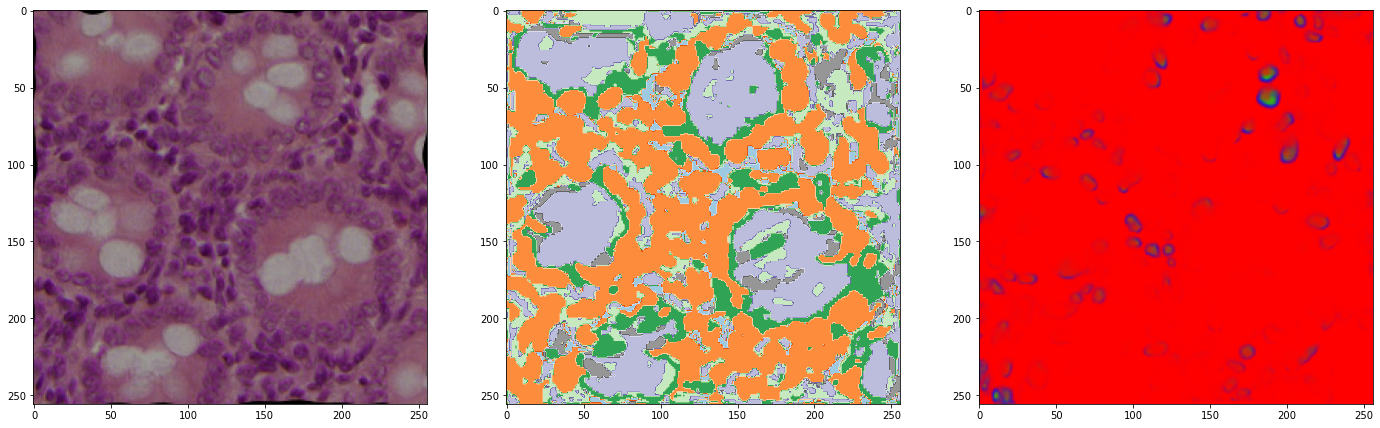

In [114]:
fig, ax = plt.subplots(1,3, figsize=(24,24))
ax[0].imshow(raw.squeeze().permute(1,2,0).cpu().detach().numpy())
ax[1].imshow(pred_class.softmax(1).argmax(1).squeeze().detach().cpu().numpy(), vmin=0, vmax=7, cmap='tab20c')
ax[2].imshow(pred_emb[:,2:].softmax(1).squeeze().permute(1,2,0).cpu().detach().numpy())
plt.show()

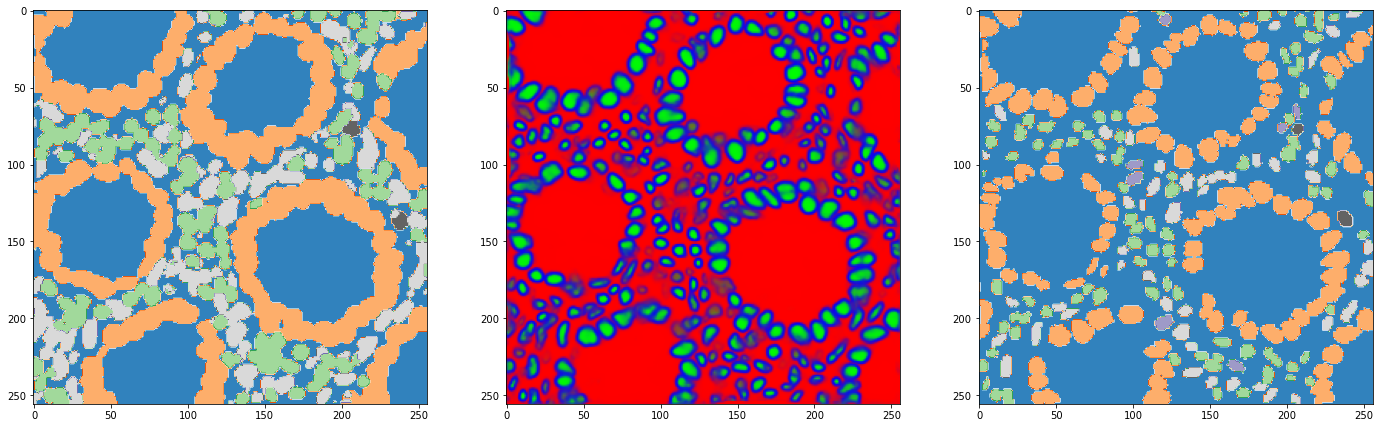

In [98]:
fig, ax = plt.subplots(1,3, figsize=(24,24))
ax[0].imshow(pred_ct.argmax(0), cmap='tab20c')
ax[1].imshow(np.transpose(pred_3c, [1,2,0]))
ax[2].imshow(np.squeeze(gt_ct), cmap='tab20c')
plt.show()

In [48]:
from src.color_conversion import Rgb2Hed, Hed2Rgb, LinearContrast
from src.data_utils import GaussianNoise
from torchvision.transforms.transforms import RandomApply, GaussianBlur, ColorJitter

def color_augmentations(size, s=0.5):
    # taken from https://github.com/sthalles/SimCLR/blob/master/data_aug/contrastive_learning_dataset.py
    """Return a set of data augmentation transformations as described in the SimCLR paper."""
    HED_contrast = torch.nn.Sequential(
                Rgb2Hed(),
                LinearContrast(alpha=(1.0,1.0)),
                Hed2Rgb())
    data_transforms = torch.nn.Sequential(
            HED_contrast)
    return data_transforms

# def color_augmentations(size, s=0.2):
#     # taken from https://github.com/sthalles/SimCLR/blob/master/data_aug/contrastive_learning_dataset.py
#     """Return a set of data augmentation transformations as described in the SimCLR paper."""
#     color_jitter = ColorJitter(0.8 * s, 0.0 * s, 0.8 * s, 0.2 * s) # brightness, contrast, saturation, hue
#     HED_contrast = torch.nn.Sequential(
#                 Rgb2Hed(),
#                 LinearContrast(alpha=(0.75,1.25)),
#                 Hed2Rgb())
#     data_transforms = torch.nn.Sequential(
#         RandomApply([
#             HED_contrast,
#             color_jitter,
#             GaussianNoise(0.005), 
#             GaussianBlur(kernel_size=3, sigma=(0.1,0.1))], p=0.5),
#         )
#     return data_transforms

In [49]:
def make_ct(pred_class, instance_map):
    device = pred_class.device
    pred_ct = torch.zeros_like(instance_map)
    pred_class_tmp = pred_class.softmax(1).squeeze(0)
    for instance in instance_map.unique():
        if instance==0:
            continue
        ct = pred_class_tmp[:,instance_map==instance].sum(1)
        #ct = ct * torch.tensor([1,2,1,1,2,2,1]).float().to(device)
        ct = ct.argmax()
        pred_ct[instance_map==instance] = ct
    return pred_ct

In [50]:
aug_params_fast = {
    'mirror': {'prob_x': 0.5, 'prob_y': 0.5, 'prob': 0.75},
    'translate': {'max_percent':0.05, 'prob': 0.0},
    'scale': {'min': 0.8, 'max':1.2, 'prob': 0.0},
    'zoom': {'min': 0.8, 'max':1.2, 'prob': 0.0},
    'rotate': {'rot90': True, 'prob': 0.75},
    'shear': {'max_percent': 0.1, 'prob': 0.0},
    'elastic': {'alpha': [120,120], 'sigma': 8, 'prob': 0.0}
}
fast_aug = SpatialAugmenter(aug_params_fast)#, padding_mode='reflection')

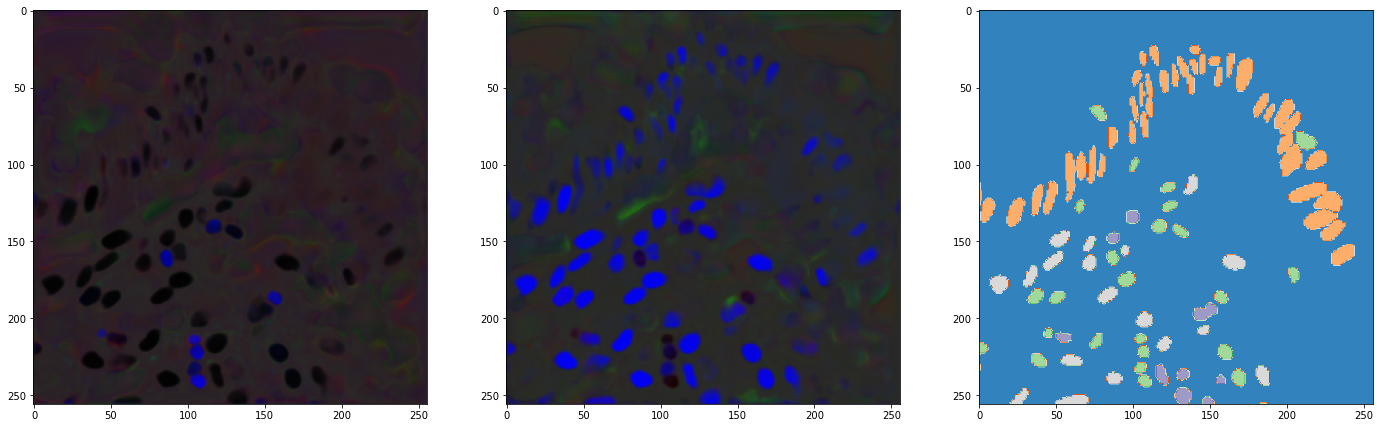

In [44]:
fig, ax = plt.subplots(1,3, figsize=(24,24))
ax[0].imshow(pred_class.softmax(1)[0,1:4].permute(1,2,0).detach().cpu().numpy())
ax[1].imshow(pred_class.softmax(1)[0,4:7].permute(1,2,0).detach().cpu().numpy())
ax[2].imshow(gt[0,1].squeeze().detach().cpu().numpy(), cmap='tab20c')
plt.show()

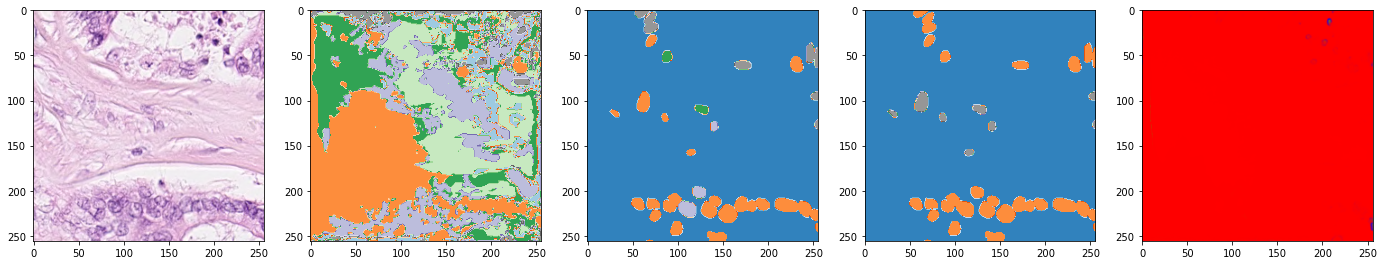

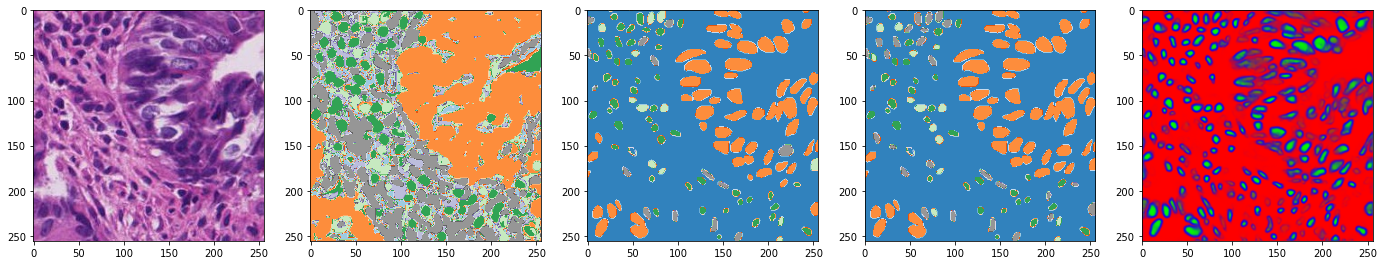

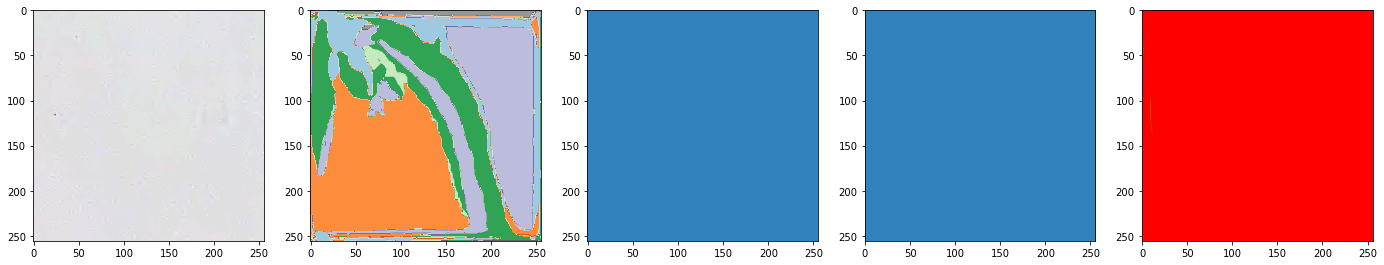

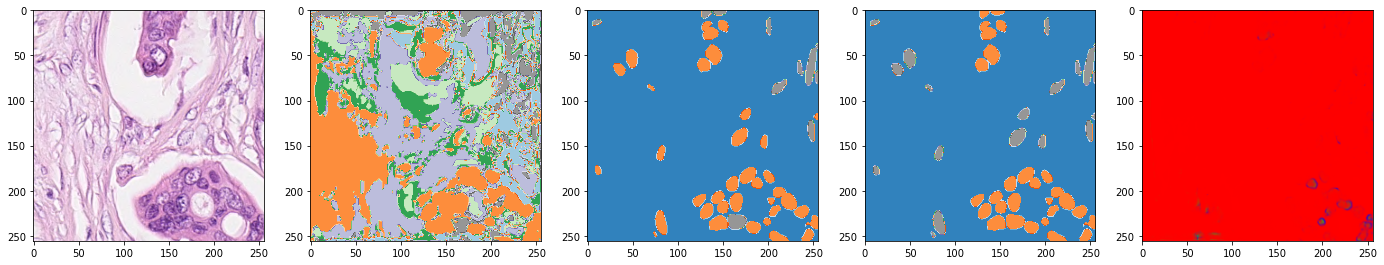

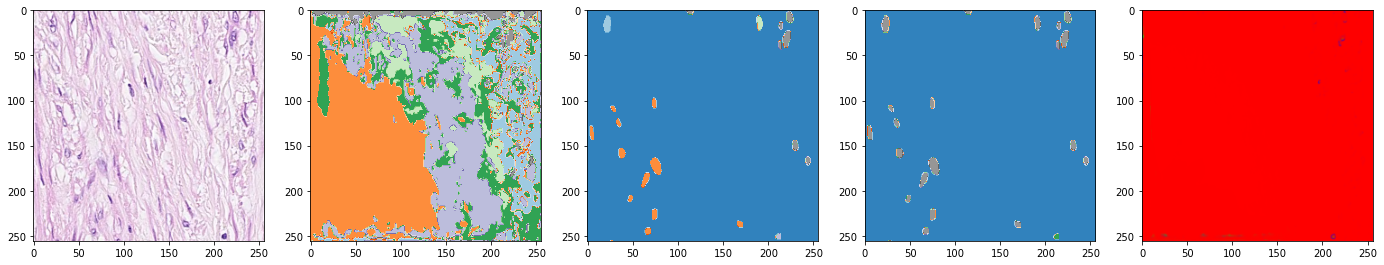

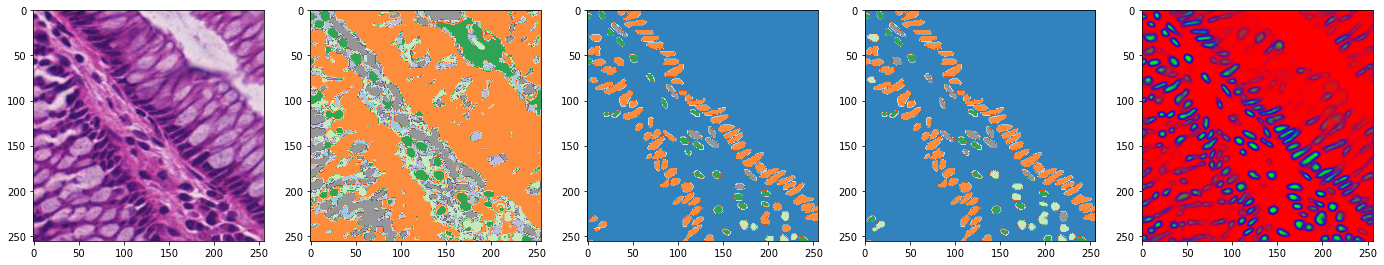

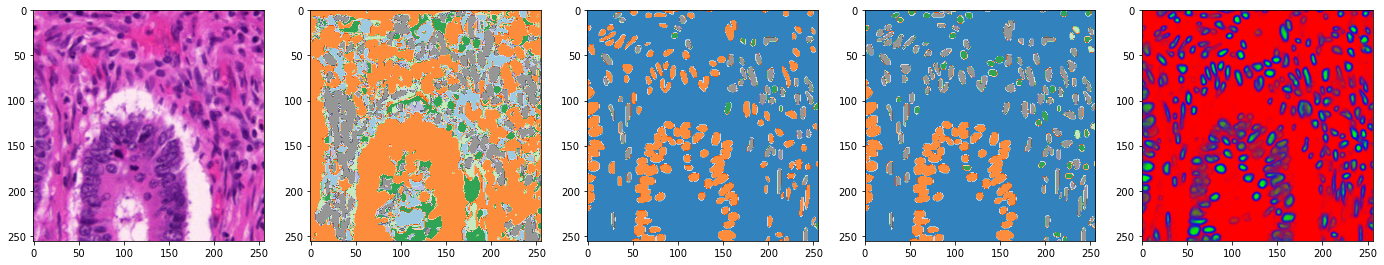

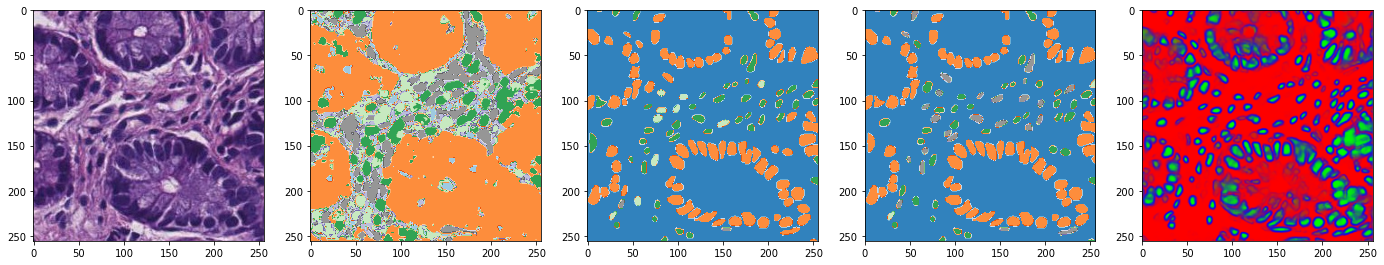

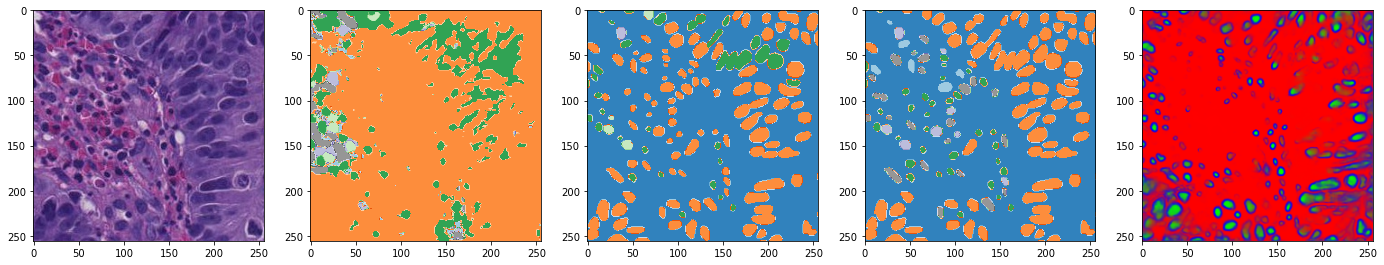

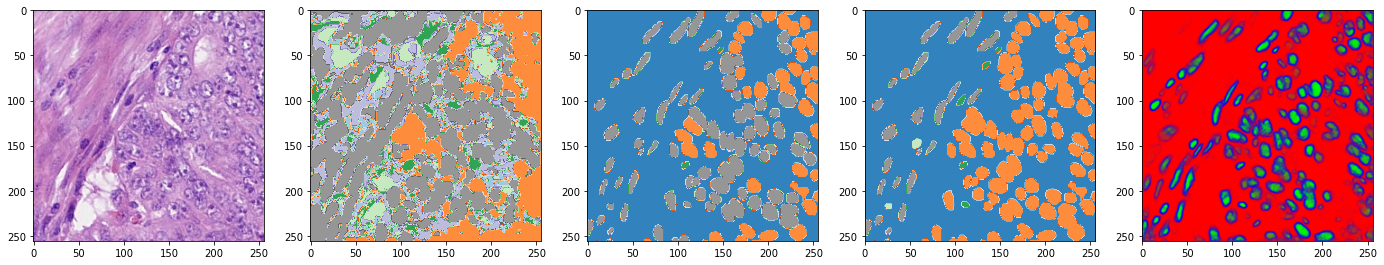

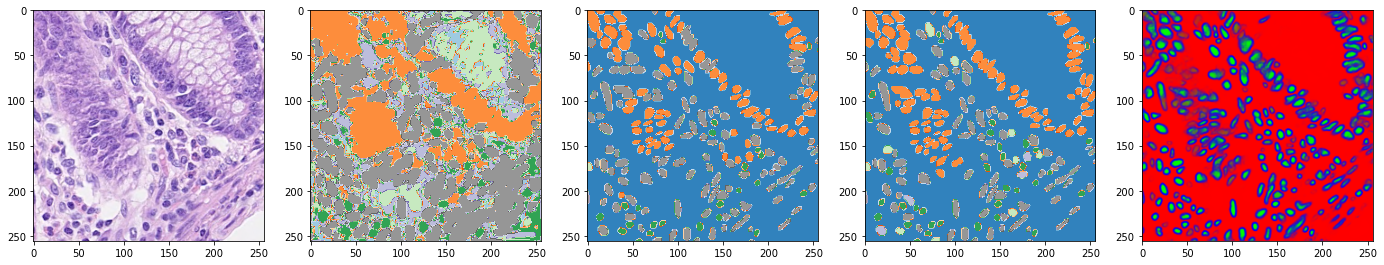

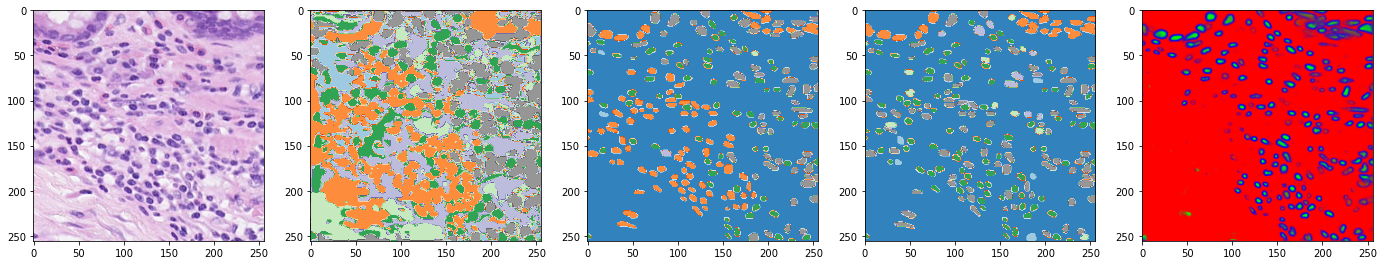

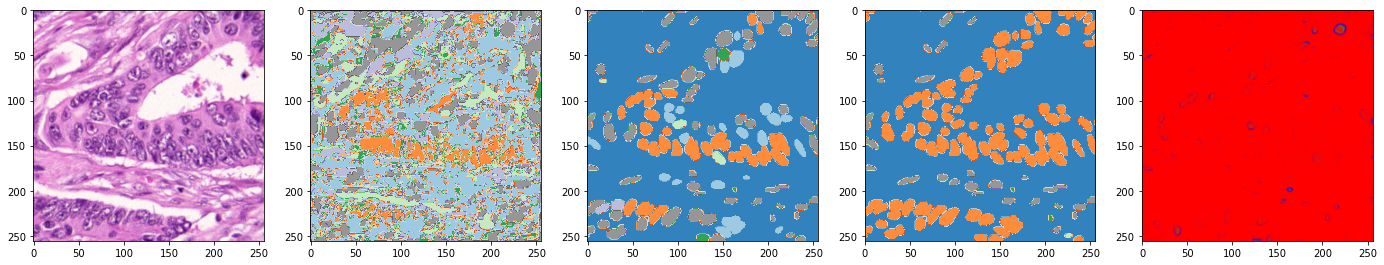

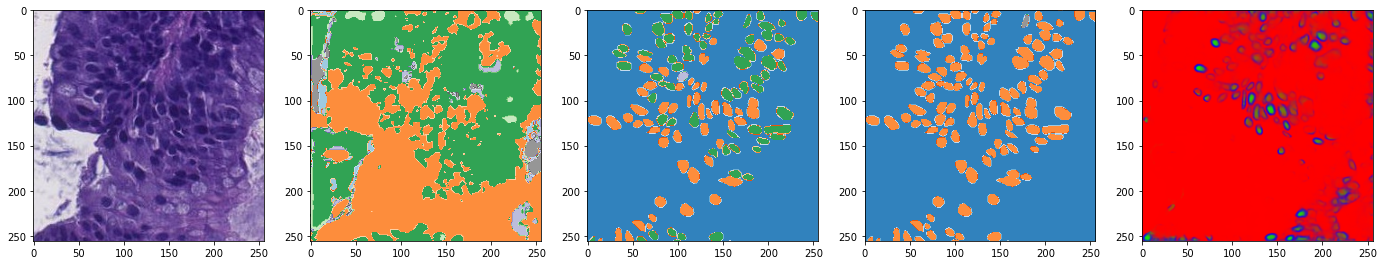

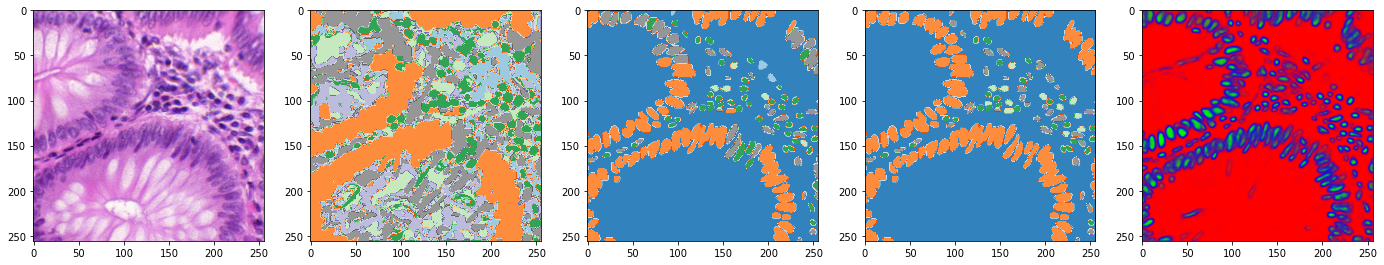

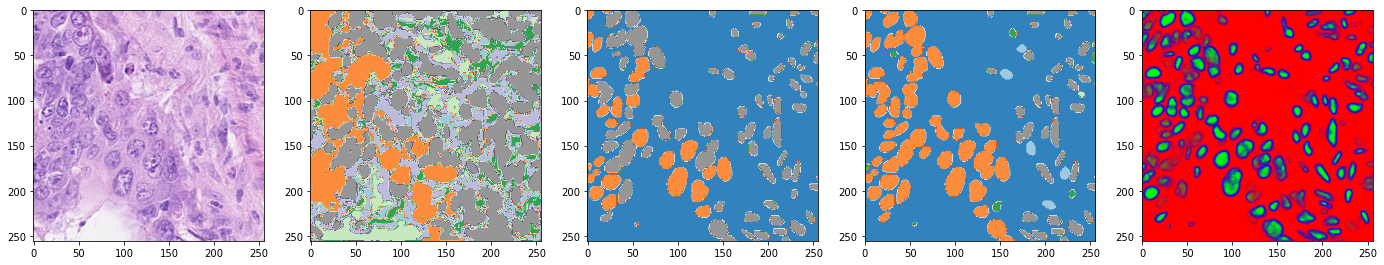

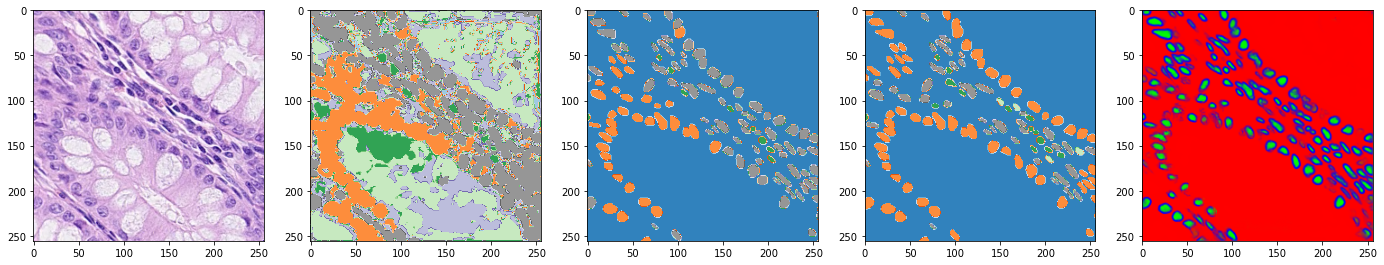

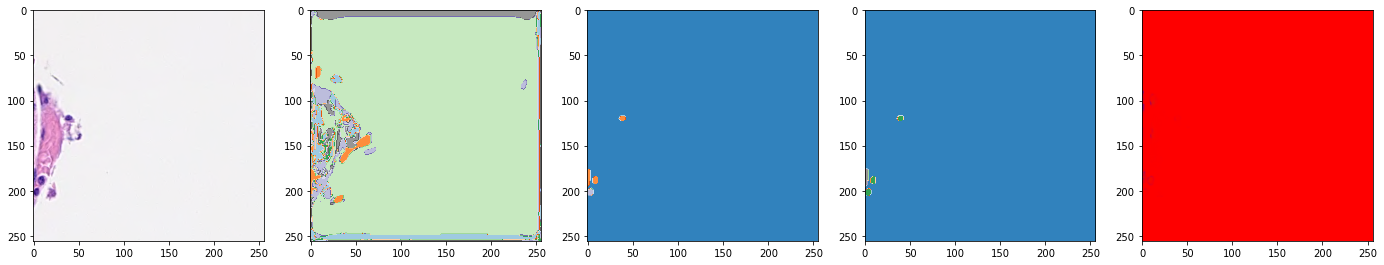

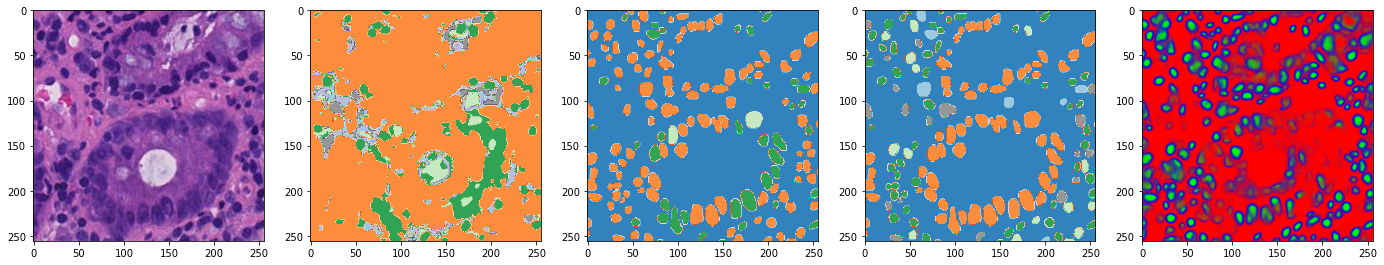

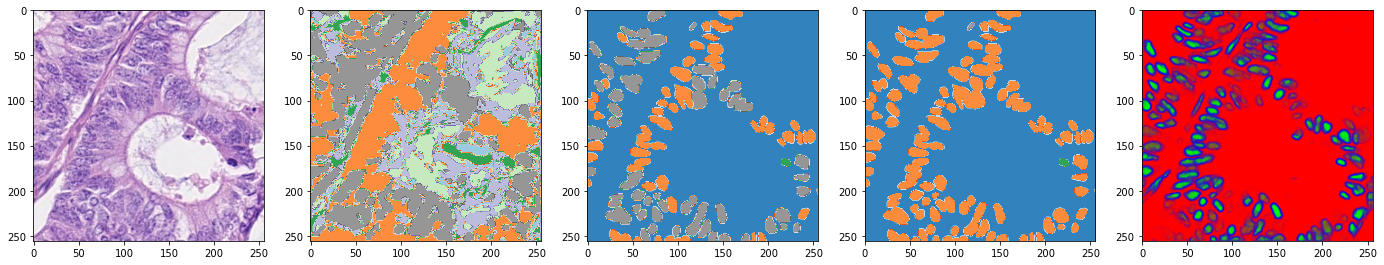

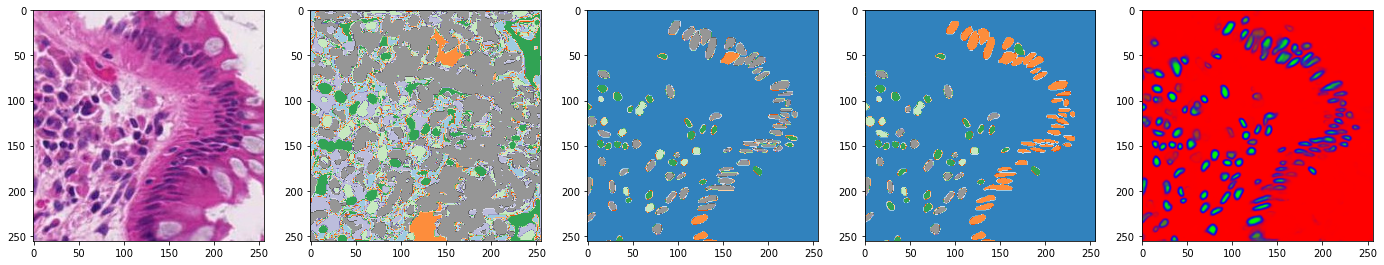

In [58]:
color_aug_fn = color_augmentations(200, s=0.5)
model = model.eval()
i = 0
cl = Cluster(grid_y=512, grid_x=512, pixel_y=1, pixel_x=1)

pred_list = []
gt_list = []
for raw, gt in labeled_dataloader:
    raw = raw.to(device).float()
    raw = raw + raw.min() *-1
    raw /= raw.max()
    gt = gt.to(device)
    raw = raw.permute(0,3,1,2) # BHWC -> BCHW
    gt = gt.permute(0,3,1,2) # BHW2 -> B2HW
    #raw = color_aug_fn(raw)
    with torch.no_grad():
        raw, gt = fast_aug.forward_transform(raw, gt)   
        out = model(raw)
        pred_emb = out[:,:5]
        pred_class = out[:,5:]
    #instance_map, instances = cl.cluster(pred_emb.squeeze(0), n_sigma=2, seed_thresh=0.4, min_mask_sum=10, min_unclustered_sum=0, min_object_size=10)
    #pred_ct = make_ct(pred_class, instance_map)
    #pred_list.append(torch.stack([instance_map, pred_ct], dim=-1).cpu().detach().numpy())
    pred_ct = make_ct(pred_class, gt[0,0].long().cpu())
    pred_list.append(torch.stack([gt[0,0].long().cpu(), pred_ct], dim=-1).cpu().detach().numpy())
    
    gt_list.append(gt.squeeze(0).permute(1,2,0).cpu().detach().numpy())
    fig, ax = plt.subplots(1,5, figsize=(24,24))
    ax[0].imshow(raw.squeeze().permute(1,2,0).cpu().detach().numpy())
    #ax[1].imshow(instance_map.numpy())
    ax[1].imshow(pred_class.softmax(1).argmax(1).squeeze().detach().cpu().numpy(), vmin=0, vmax=7, cmap='tab20c')
    ax[2].imshow(pred_ct.cpu().detach().numpy(), vmin=0, vmax=7, cmap='tab20c')
    ax[3].imshow(gt[:,1].squeeze().cpu().detach().numpy(), vmin=0, vmax=7, cmap='tab20c')
    ax[4].imshow(pred_emb[:,2:].softmax(1).squeeze().permute(1,2,0).cpu().detach().numpy())
    plt.show()
    i += 1
    if i>20:
        break

In [14]:
import pandas as pd
from tqdm.auto import tqdm
from src.metrics import *

mode = 'seg_class'
pred_array = np.stack(pred_list, axis=0)
true_array = np.stack(gt_list, axis=0)

seg_metrics_names = ["pq", "multi_pq+"]
reg_metrics_names = ["r2"]

all_metrics = {}
if mode == "seg_class":
    # check to make sure input is a single numpy array
#     pred_format = pred_path.split(".")[-1]
#     true_format = true_path.split(".")[-1]
#     if pred_format != "npy" or true_format != "npy":
#         raise ValueError("pred and true must be in npy format.")

    # initialise empty placeholder lists
    pq_list = []
    mpq_info_list = []
    # load the prediction and ground truth arrays
    #pred_array = np.load(pred_path)
    #true_array = np.load(true_path)

    nr_patches = pred_array.shape[0]

    for patch_idx in tqdm(range(nr_patches)):
        # get a single patch
        pred = pred_array[patch_idx]
        true = true_array[patch_idx]

        # instance segmentation map
        pred_inst = pred[..., 0]
        true_inst = true[..., 0]
        # classification map
        pred_class = pred[..., 1]
        true_class = true[..., 1]

        # ===============================================================

        for idx, metric in enumerate(seg_metrics_names):
            if metric == "pq":
                # get binary panoptic quality
                pq = get_pq(true_inst, pred_inst)
                pq = pq[0][2]
                pq_list.append(pq)
            elif metric == "multi_pq+":
                # get the multiclass pq stats info from single image
                mpq_info_single = get_multi_pq_info(true, pred)
                mpq_info = []
                # aggregate the stat info per class
                for single_class_pq in mpq_info_single:
                    tp = single_class_pq[0]
                    fp = single_class_pq[1]
                    fn = single_class_pq[2]
                    sum_iou = single_class_pq[3]
                    mpq_info.append([tp, fp, fn, sum_iou])
                mpq_info_list.append(mpq_info)
            else:
                raise ValueError("%s is not supported!" % metric)

    pq_metrics = np.array(pq_list)
    pq_metrics_avg = np.mean(pq_metrics, axis=-1)  # average over all images
    if "multi_pq+" in seg_metrics_names:
        mpq_info_metrics = np.array(mpq_info_list, dtype="float")
        # sum over all the images
        total_mpq_info_metrics = np.sum(mpq_info_metrics, axis=0)

    for idx, metric in enumerate(seg_metrics_names):
        if metric == "multi_pq+":
            mpq_list = []
            # for each class, get the multiclass PQ
            for cat_idx in range(total_mpq_info_metrics.shape[0]):
                total_tp = total_mpq_info_metrics[cat_idx][0]
                total_fp = total_mpq_info_metrics[cat_idx][1]
                total_fn = total_mpq_info_metrics[cat_idx][2]
                total_sum_iou = total_mpq_info_metrics[cat_idx][3]

                # get the F1-score i.e DQ
                dq = total_tp / (
                    (total_tp + 0.5 * total_fp + 0.5 * total_fn) + 1.0e-6
                )
                # get the SQ, when not paired, it has 0 IoU so does not impact
                sq = total_sum_iou / (total_tp + 1.0e-6)
                mpq_list.append(dq * sq)
            mpq_metrics = np.array(mpq_list)
            all_metrics[metric] = [np.mean(mpq_metrics)]
        else:
            all_metrics[metric] = [pq_metrics_avg]

else:
    # first check to make sure ground truth and prediction is in csv format
    if not os.path.isfile(true_path) or not os.path.isfile(pred_path):
        raise ValueError("pred and true must be in csv format.")

    pred_format = pred_path.split(".")[-1]
    true_format = true_path.split(".")[-1]
    if pred_format != "csv" or true_format != "csv":
        raise ValueError("pred and true must be in csv format.")

    pred_csv = pd.read_csv(pred_path)
    true_csv = pd.read_csv(true_path)

    for idx, metric in enumerate(reg_metrics_names):
        if metric == "r2":
            # calculate multiclass coefficient of determination
            r2 = get_multi_r2(true_csv, pred_csv)
            all_metrics["multi_r2"] = [r2]
        else:
            raise ValueError("%s is not supported!" % metric)

df = pd.DataFrame(all_metrics)
df = df.to_string(index=False)
print(df)


  0%|          | 0/31 [00:00<?, ?it/s]

 pq  multi_pq+
1.0   0.362773


|        |PQ |mPQ+|multi_r2|
|--------|------|------|------|
|baseline|0.6149|0.4998|0.8585|
|ours    |      |      |      |

In [31]:
def degrid(meter, grid_size, pixel_size):
    return int(meter * (grid_size-1) / pixel_size + 1)

class Cluster:

    def __init__(self, grid_y, grid_x, pixel_y, pixel_x, one_hot=False):

        xm = torch.linspace(0, pixel_x, grid_x).view(1, 1, -1).expand(1, grid_y, grid_x)
        ym = torch.linspace(0, pixel_y, grid_y).view(1, -1, 1).expand(1, grid_y, grid_x)
        xym = torch.cat((xm, ym), 0)

        self.xym = xym.cuda()
        self.one_hot = one_hot
        self.grid_x = grid_x
        self.grid_y = grid_y
        self.pixel_x = pixel_x
        self.pixel_y = pixel_y

    def cluster_with_gt(self, prediction, instance, n_sigma=1, ):
        height, width = prediction.size(1), prediction.size(2)

        xym_s = self.xym[:, 0:height, 0:width]  # 2 x h x w

        spatial_emb = torch.tanh(prediction[0:2]) + xym_s  # 2 x h x w
        sigma = prediction[2:2 + n_sigma]  # n_sigma x h x w

        instance_map = torch.zeros(height, width).short().cuda()
        if (self.one_hot):
            unique_instances = torch.arange(instance.size(0))
        else:
            unique_instances = instance.unique()
            unique_instances = unique_instances[unique_instances != 0]

        for id in unique_instances:
            if (self.one_hot):
                mask = instance[id].eq(1).view(1, height, width)
            else:
                mask = instance.eq(id).view(1, height, width)

            center = spatial_emb[mask.expand_as(spatial_emb)].view(
                2, -1).mean(1).view(2, 1, 1)  # 2 x 1 x 1

            s = sigma[mask.expand_as(sigma)].view(n_sigma, -1).mean(1).view(n_sigma, 1, 1)

            s = torch.exp(s * 10)  # n_sigma x 1 x 1 #
            dist = torch.exp(-1 * torch.sum(torch.pow(spatial_emb - center, 2) * s, 0))
            proposal = (dist > 0.5)
            if (self.one_hot):
                instance_map[proposal] = id.item() + 1 # TODO
            else:
                instance_map[proposal] = id.item() #TODO

        return instance_map

    def cluster(self, prediction, n_sigma=2, seed_thresh=0.5, min_mask_sum=128, min_unclustered_sum=0, min_object_size=36):

        height, width = prediction.size(1), prediction.size(2)
        xym_s = self.xym[:, 0:height, 0:width]

        spatial_emb = torch.tanh(prediction[0:2]) + xym_s  # 2 x h x w

        sigma = prediction[2:2 + n_sigma]  # n_sigma x h x w
        seed_map = torch.sigmoid(prediction[2 + n_sigma:2 + n_sigma + 1])  # 1 x h x w

        instance_map = torch.zeros(height, width).long()
        instances = []  # list

        count = 1
        mask = seed_map > seed_thresh

        if mask.sum() > min_mask_sum:

            spatial_emb_masked = spatial_emb[mask.expand_as(spatial_emb)].view(n_sigma, -1)
            sigma_masked = sigma[mask.expand_as(sigma)].view(n_sigma, -1)
            seed_map_masked = seed_map[mask].view(1, -1)

            unclustered = torch.ones(mask.sum()).long().cuda()
            instance_map_masked = torch.zeros(mask.sum()).long().cuda()

            while (unclustered.sum() > min_unclustered_sum):
                seed = (seed_map_masked * unclustered.float()).argmax().item()
                seed_score = (seed_map_masked * unclustered.float()).max().item()
                if seed_score < seed_thresh:
                    break
                center = spatial_emb_masked[:, seed:seed + 1]
                unclustered[seed] = 0

                s = torch.exp(sigma_masked[:, seed:seed + 1] * 10)
                dist = torch.exp(-1 * torch.sum(torch.pow(spatial_emb_masked - center, 2) * s, 0))

                proposal = (dist > 0.5).squeeze()
                if proposal.sum() > min_object_size:
                    if unclustered[proposal].sum().float() / proposal.sum().float() > 0.5:
                        instance_map_masked[proposal.squeeze()] = count
                        instance_mask = torch.zeros(height, width).long()
                        instance_mask[mask.squeeze().cpu()] = proposal.long().cpu()  # TODO
                        center_image = torch.zeros(height, width).long()

#                         center[0] = int(degrid(center[0].cpu().detach().numpy(), self.grid_x, self.pixel_x))
#                         center[1] = int(degrid(center[1].cpu().detach().numpy(), self.grid_y, self.pixel_y))
#                         center_image[int(center[1].item()), int(center[0].item())] = True
#                         instances.append(
#                             {'mask': instance_mask.squeeze() * 255, 'score': seed_score,
#                              'center-image': center_image})
                        count += 1

                unclustered[proposal] = 0

            instance_map[mask.squeeze().cpu()] = instance_map_masked.cpu()

        return instance_map, instances